In [8]:
import sys
import logging
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr
from scipy.signal import detrend

sys.path.append('..')
from Weave.utils import spearmanr_wrap, spearmanr_cv, spearmanr_par, agg_time, scipy_stats_decorator, bootstrap

In [3]:
f = bootstrap(10,scipy_stats_decorator(spearmanr)
data = np.random.randint(0,10,(10000,2))

In [5]:
%timeit spearmanr(data)

1.98 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
f(data)

SpearmanrResult(correlation=-0.024992654648455286, pvalue=0.012442367504550522)

In [10]:
spearmanr_wrap(data)

SpearmanrResult(correlation=-0.024992654648455286, pvalue=0.012442367504550522)

In [2]:
t2m = xr.open_dataarray('/scistor/ivm/jsn295/processed/t2m_europe.anom.nc').sel(latitude = 52, longitude = 6).load()
swvl = xr.open_dataarray('/scistor/ivm/jsn295/processed/swvl13_europe.anom.nc').sel(latitude = 52, longitude = 6).load()

In [39]:
timeaggs = [1,3,5,7,11,15,21,31]
separations = [0,-1,-3,-5,-7,-11,-15,-21,-31]
results = pd.DataFrame(np.zeros((len(timeaggs)*len(separations),2)), columns = ['cor','parcor'], index = pd.MultiIndex.from_product([timeaggs,separations], names = ['timeagg','separation']))
for timeagg in timeaggs:
    y_agg = agg_time(t2m, ndayagg=timeagg, rolling = True).sel(time = slice('1981','2018',None))
    # merge with lag -1 of itself (zeroth column itself)
    y_agg_m1 = xr.DataArray(np.column_stack([y_agg[timeagg:],y_agg[:-timeagg]]), dims = ('time','what'), coords = {'time':y_agg.coords['time'][timeagg:],'what':['t','t-1']})
    y_agg = y_agg.loc[y_agg.time.dt.season == 'JJA']
    y_agg.values = detrend(y_agg, axis = 0)
    y_agg_m1 = y_agg_m1.loc[y_agg_m1.time.dt.season == 'JJA']
    y_agg_m1.values = detrend(y_agg_m1, axis = 0)
    
    X_agg = agg_time(swvl, ndayagg=timeagg, rolling = True)
    
    for separation in separations:
        X = X_agg.copy()
        X.coords['time'] = X.coords['time'] - pd.Timedelta(abs(separation) + timeagg, 'days')    
        X_m1 = xr.DataArray(np.column_stack([X[timeagg:],X[:-timeagg]]), dims = ('time','what'), coords = {'time':X.coords['time'][timeagg:],'what':['t','t-1']})
        X = X.reindex_like(y_agg)
        X.values = detrend(X, axis = 0)
        X_m1 = X_m1.reindex_like(y_agg)
        X_m1.values = detrend(X_m1, axis = 0)
        cor, _ = spearmanr(a = y_agg, b = X)
        parcor, _ = spearmanr_par(a = y_agg_m1, b = X_m1)
        results.loc[(timeagg,separation)] = [cor,parcor]

#a = np.column_stack([t2m[1:],t2m[:-1]]) # First column is concurrent. 2nd is value from one step back
#b = np.column_stack([z300[1:],z300[:-1]]) 

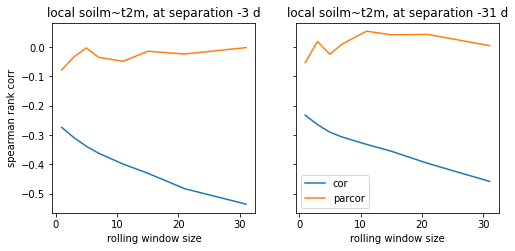

In [40]:
fix, axes = plt.subplots(nrows= 1, ncols = 2, sharex=True, sharey=True, figsize = (8,3.5))
unrelated = results.loc[(slice(None),-3),:]
axes[0].plot(unrelated.index.get_level_values('timeagg'), unrelated)
axes[0].set_ylabel('spearman rank corr')
axes[0].set_xlabel('rolling window size')
axes[0].set_title('local soilm~t2m, at separation -3 d')
related = results.loc[(slice(None),-31),:]
axes[1].plot(unrelated.index.get_level_values('timeagg'), related)
axes[1].set_title('local soilm~t2m, at separation -31 d')
axes[1].set_xlabel('rolling window size')
axes[1].legend(labels = related.columns.tolist())

['cor', 'parcor']